In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install --upgrade music21
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore
!apt-get install xvfb

from music21 import *

# Настраиваем окружение
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [ ]:
import tensorflow
import os
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import fluidsynth

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import keras.backend as K
from keras.optimizers import Adamax

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)


In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip
!unzip -qo "classical-music-midi.zip" -d ./dataset
!dir ./dataset

# Список композиторов
CLASS_LIST = ["Chopin"]

all_midis = []
for compositor in CLASS_LIST:
    filepath = f"./dataset/{compositor}/"
    for i in os.listdir(filepath):
        if i.endswith(".mid"):
            tr = filepath + i

            # Чтение и парсинг MIDI-файлов в Stream-объект библиотеки music21
            midi = converter.parse(tr)
            all_midis.append(midi)


--2024-06-18 20:52:25--  https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2751606 (2.6M) [application/x-zip-compressed]
Saving to: ‘classical-music-midi.zip’

classical-music-mid 100%[===================>]   2.62M  1.28MB/s    in 2.1s    

2024-06-18 20:52:28 (1.28 MB/s) - ‘classical-music-midi.zip’ saved [2751606/2751606]

Albeniz    Borodin	Christmas  Granados  Mendelssohn  Rachmaninoff	Sinding
Bach	   Brahms	Clementi   Grieg     Moszkowski   Ravel		Tchaikovsky
Balakirev  Burgmueller	Debussy    Haydn     Mozart	  Schubert
Beethoven  Chopin	Godowsky   Liszt     Mussorgsky   Schumann


In [ ]:
def get_notes(file):
    notes = []
    notes_to_parse = None
    for j in file:
        # Получение инструментов из Stream-объекта
        songs = instrument.partitionByInstrument(j)

        # Цикл по всем инструментам
        for part in songs.parts:
            notes_to_parse = part.recurse()
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))
    return notes

def chords_n_notes(chunk):
    Melody = []
    offset = 0  # Счетчик
    for i in chunk:
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".")
            notes = []
            for j in chord_notes:
                inst_note = int(j)
                note_chunk = note.Note(inst_note)
                notes.append(note_chunk)
                chord_chunk = chord.Chord(notes)
                chord_chunk.offset = offset
                Melody.append(chord_chunk)
        else:
            note_chunk = note.Note(i)
            note_chunk.offset = offset
            Melody.append(note_chunk)
        offset += 1
    return Melody


Всего нот во всех MIDI-файлах всего датасета: 57894
Первые 50 нот в корпусе: ['E-3', 'C2', 'G3', 'G2', 'E-4', 'C3', 'E-4', 'C3', 'G4', 'G3', 'E-5', 'C4', 'E-5', 'C4', 'G5', 'G4', 'E-6', 'C5', 'G5', 'G4', 'E-5', 'C4', 'E-5', 'C4', 'G4', 'G3', 'E-4', 'C3', 'E-4', 'C3', 'G3', 'G2', 'D3', 'C2', 'G#3', 'F2', 'D4', 'C3', 'D4', 'C3', 'G#4', 'F3', 'D5', 'C4', 'D5', 'C4', 'G#5', 'F4', 'D6', 'C5']
Общее число уникальных нот в корпусе: 397
Средняя повторяемость ноты: 145.8287153652393
Наиболее часто встречаемые ноты: 1627 раз
Наиболее редкие ноты: 1 раз


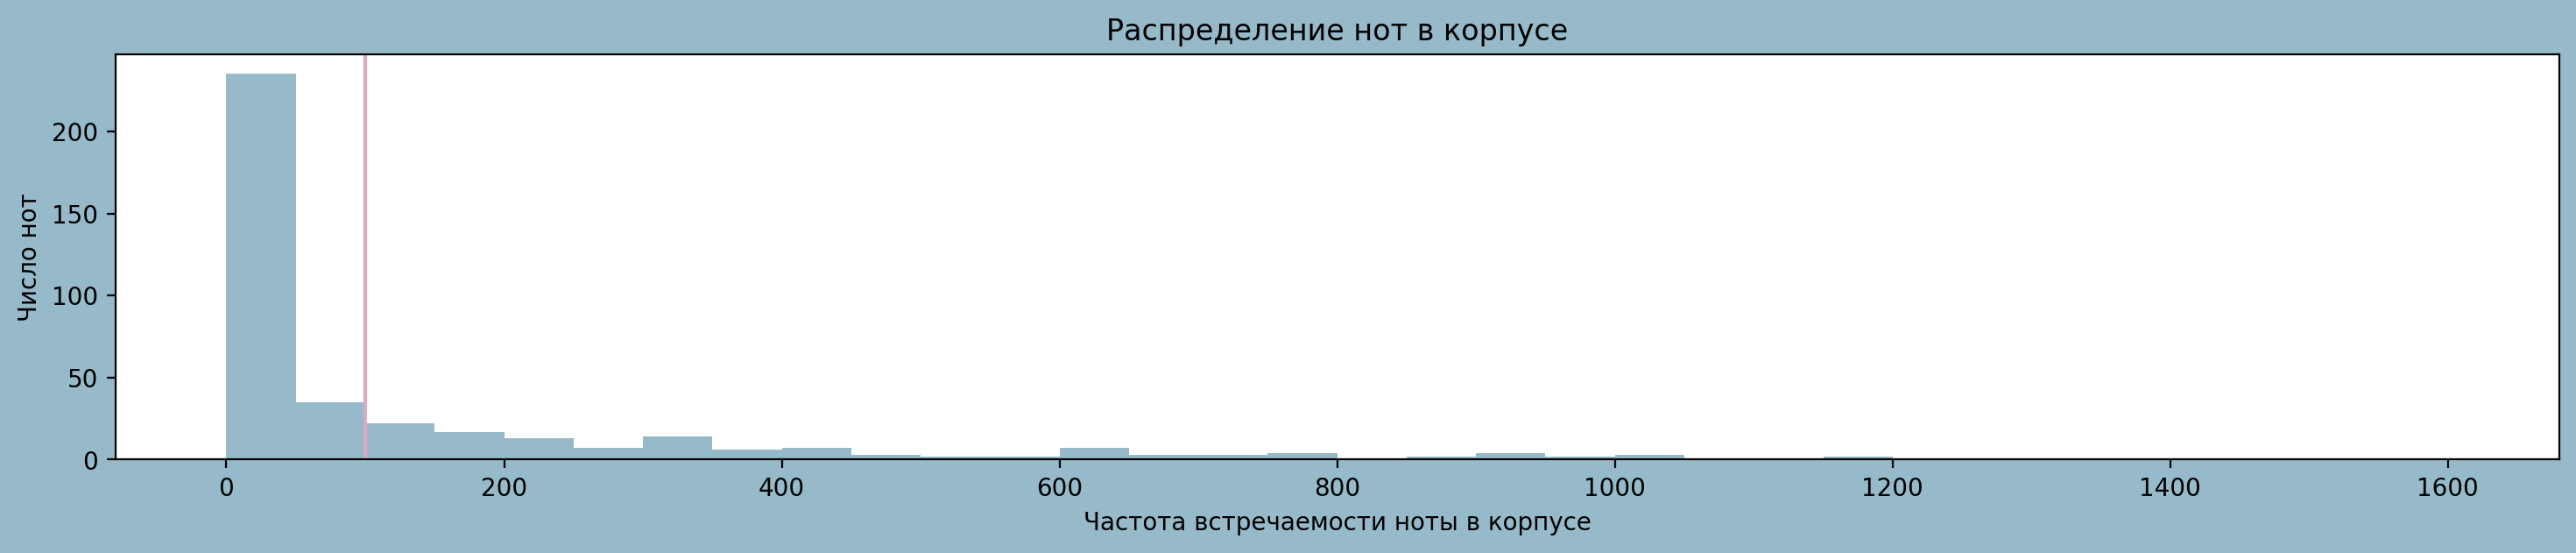

Общее число нот, которые повторяются менее 100 раз: 270
Длина корпуса после исключения редких нот: 53753
Общее число символов: 53753
Число уникальных символов: 264


In [ ]:
Corpus = get_notes(all_midis)
print("Всего нот во всех MIDI-файлах всего датасета:", len(Corpus))
print("Первые 50 нот в корпусе:", Corpus[:50])

# Анализ данных
count_num = Counter(Corpus)
print("Общее число уникальных нот в корпусе:", len(count_num))

Notes = list(count_num.keys())
Recurrence = list(count_num.values())

def average(rec):
    return sum(rec) / len(rec)

print('Средняя повторяемость ноты:', average(Recurrence))
print('Наиболее часто встречаемые ноты:', max(Recurrence), 'раз')
print('Наиболее редкие ноты:', min(Recurrence), 'раз')

plt.figure(figsize=(18, 3), facecolor='#97BACB')
bins = np.arange(0, (max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins, color='#97BACB')
plt.axvline(x=100, color='#DBACC1')
plt.title('Распределение нот в корпусе')
plt.xlabel('Частота встречаемости ноты в корпусе')
plt.ylabel('Число нот')
plt.show()

# Исключение редких нот
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        rare_note.append(key)

print("Общее число нот, которые повторяются менее 100 раз:", len(rare_note))

for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Длина корпуса после исключения редких нот:", len(Corpus))

# Сохранение всех уникальных значений корпуса
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus)
L_symb = len(symb)

# Создание словаря для доступа к словарному запасу из индексов и наоборот
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Общее число символов:", L_corpus)
print("Число уникальных символов:", L_symb)


In [ ]:
length = 40
features = []
targets = []

for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])

L_datapoints = len(targets)
print("Общее количество последовательностей в корпусе:", L_datapoints)

X = (np.reshape(features, (L_datapoints, length, 1))) / float(L_symb)
y = tensorflow.keras.utils.to_categorical(targets)

X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)


Общее количество последовательностей в корпусе: 53713


Epoch 1/150
168/168 [==============================] - 8s 16ms/step - loss: 4.7606 - acc: 0.0246
Epoch 2/150
168/168 [==============================] - 3s 17ms/step - loss: 4.6857 - acc: 0.0266
Epoch 3/150
168/168 [==============================] - 3s 16ms/step - loss: 4.6727 - acc: 0.0280
Epoch 4/150
168/168 [==============================] - 3s 16ms/step - loss: 4.6709 - acc: 0.0289
Epoch 5/150
168/168 [==============================] - 3s 16ms/step - loss: 4.5284 - acc: 0.0331
Epoch 6/150
168/168 [==============================] - 3s 16ms/step - loss: 4.4580 - acc: 0.0351
Epoch 7/150
168/168 [==============================] - 3s 17ms/step - loss: 4.4440 - acc: 0.0369
Epoch 8/150
168/168 [==============================] - 3s 16ms/step - loss: 4.4321 - acc: 0.0376
Epoch 9/150
168/168 [==============================] - 3s 16ms/step - loss: 4.4300 - acc: 0.0377
Epoch 10/150
168/168 [==============================] - 3s 16ms/step - loss: 4.4215 - acc: 0.0374
Epoch 11/150
168/168 [=======

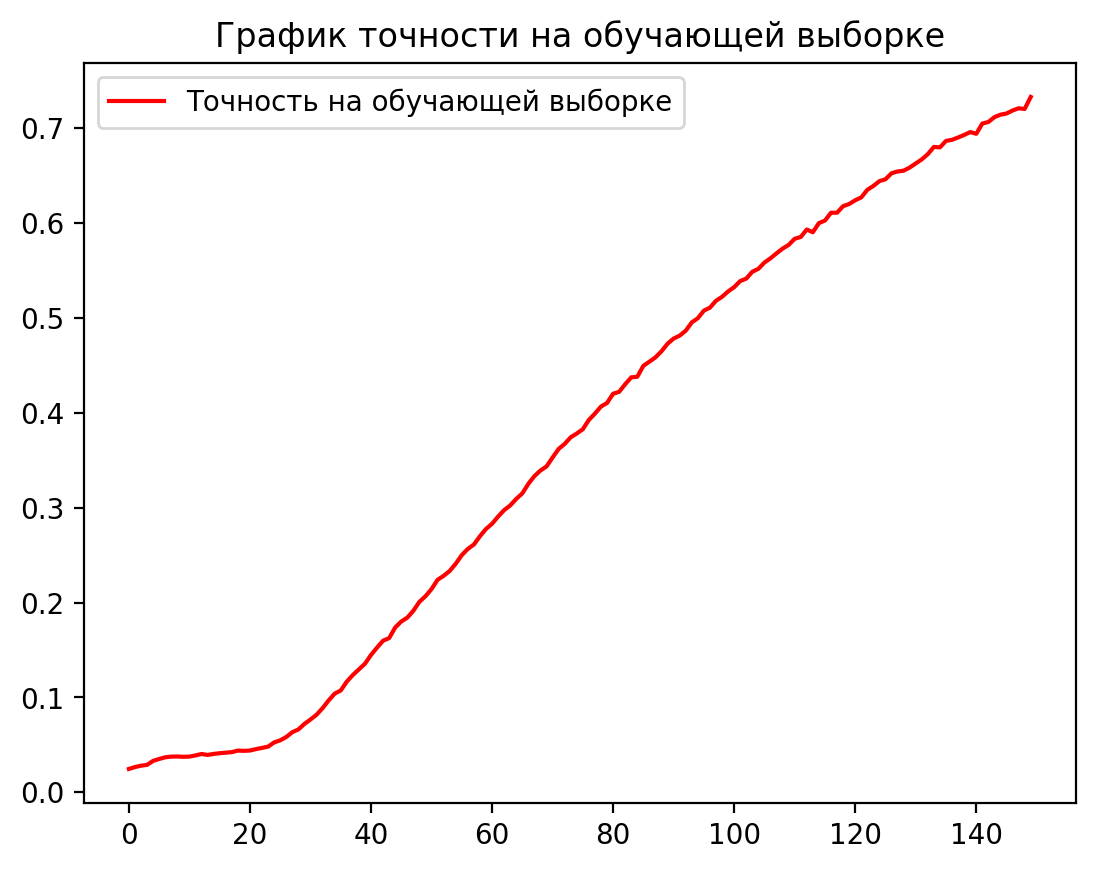

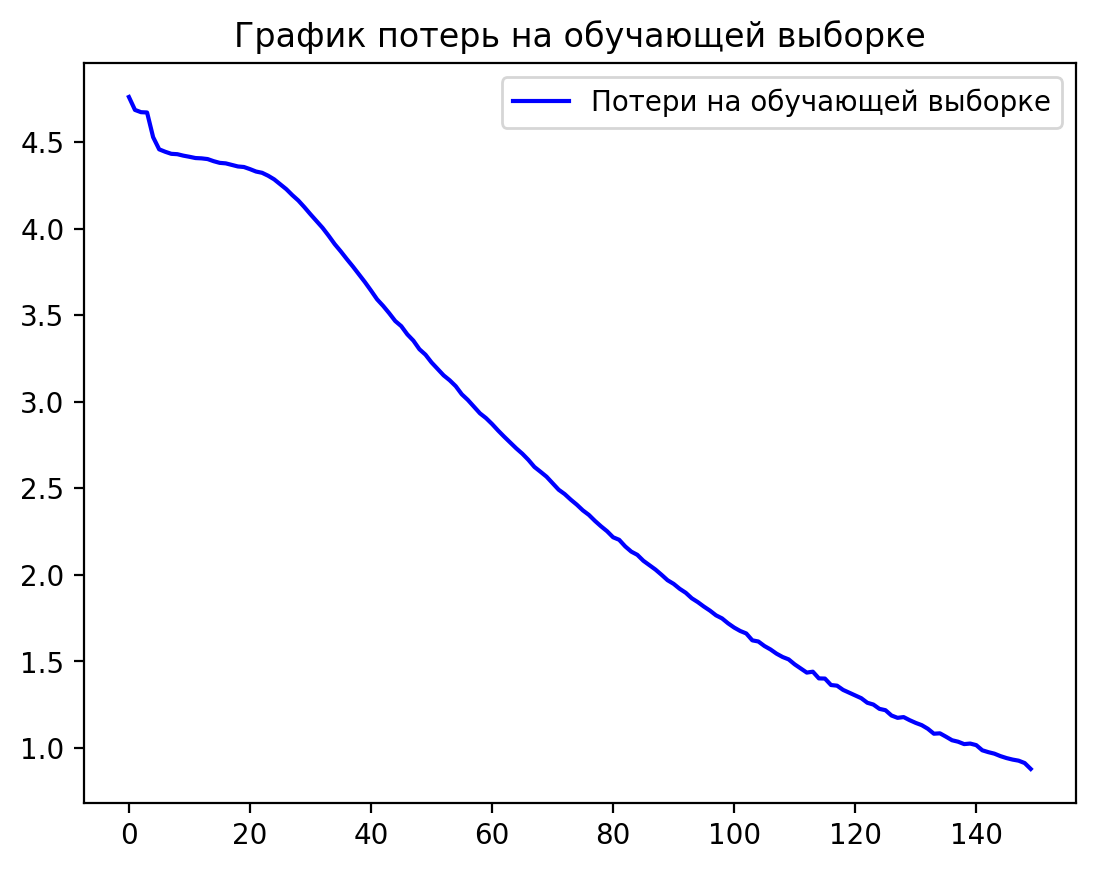

In [ ]:
model = Sequential()

model.add(LSTM(256, input_shape=X.shape[1:], return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(128))
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

history = model.fit(X_train, y_train, batch_size=256, epochs=150)

plt.plot(history.epoch, history.history['acc'], 'r', label='Точность на обучающей выборке')
plt.title('График точности на обучающей выборке')
plt.legend()
plt.figure()
plt.plot(history.epoch, history.history['loss'], 'b', label='Потери на обучающей выборке')
plt.title('График потерь на обучающей выборке')
plt.legend()
plt.show()


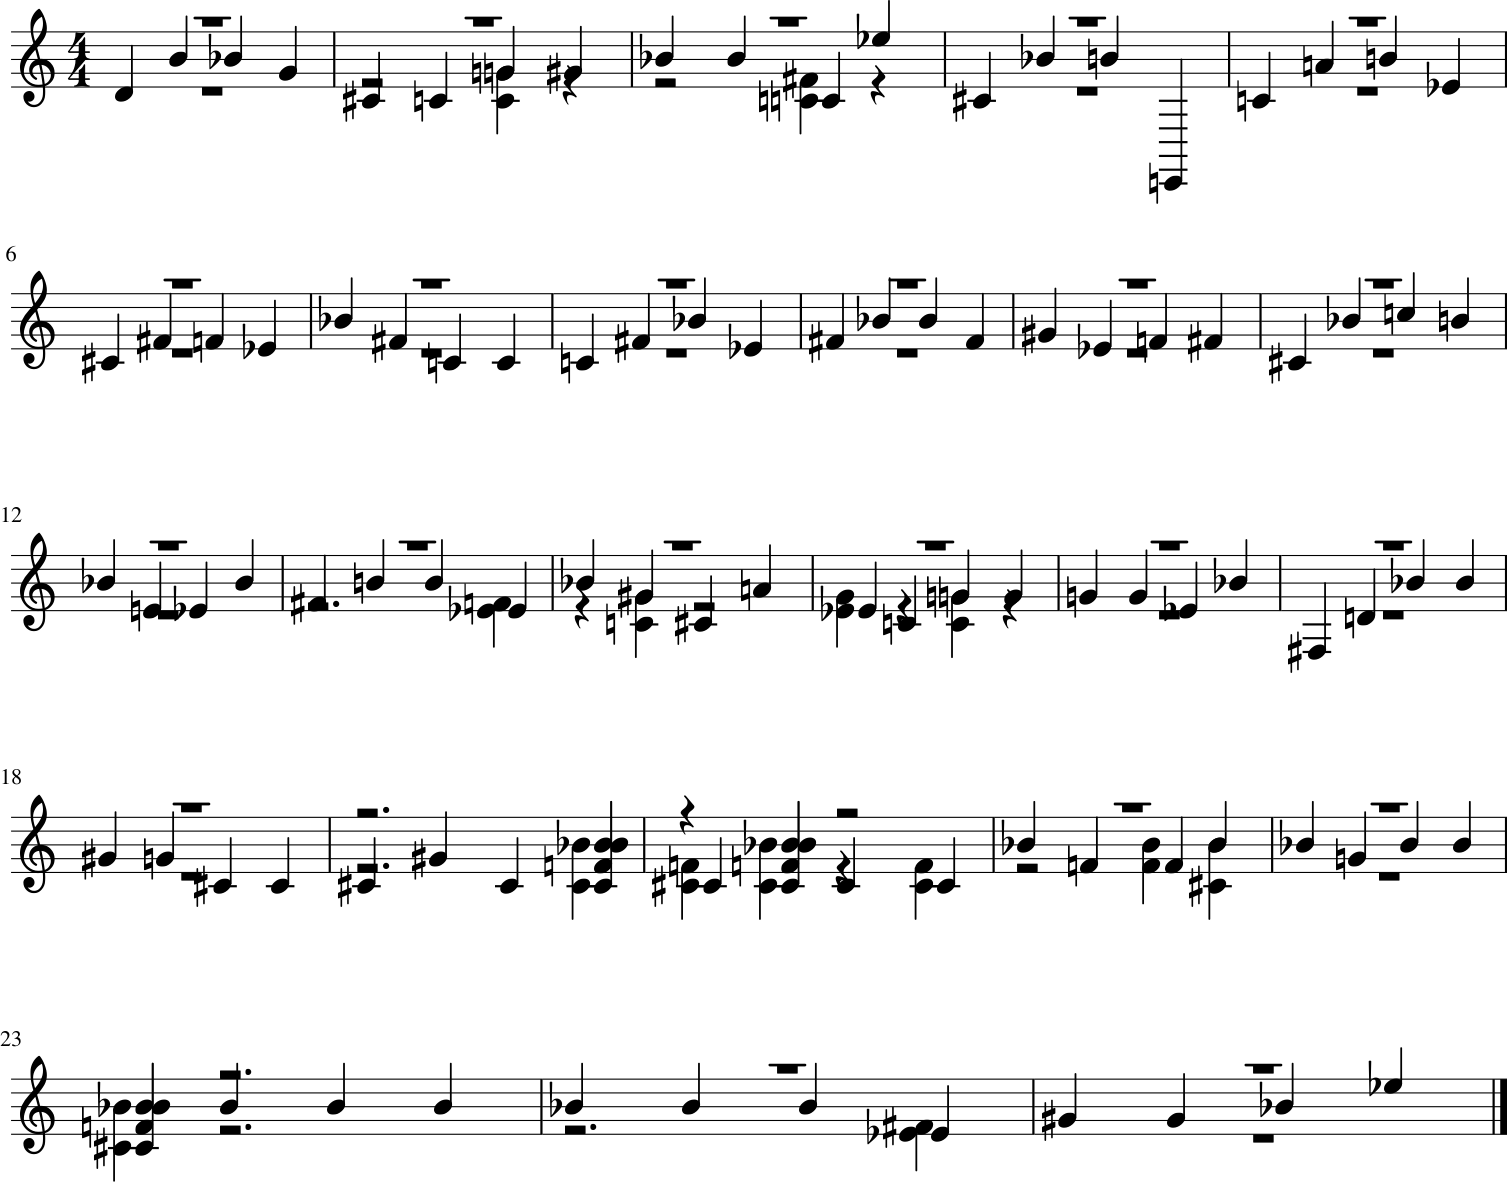

In [ ]:
def music_generator(seq_len, temperature=1.0):
    seed = X_seed[np.random.randint(0, len(X_seed)-1)]
    music = []
    notes = []
    for i in range(seq_len):
        seed = seed.reshape(1, length, 1)
        prediction = model.predict(seed, verbose=0)[0]

        prediction = np.log(prediction) / temperature
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)

        index = np.random.choice(range(len(prediction)), p=prediction)
        index_N = index / float(L_symb)

        notes.append(index)
        music = [reverse_mapping[char] for char in notes]

        seed = np.insert(seed[0], len(seed[0]), index_N)
        seed = seed[1:]

    return chords_n_notes(music)
def save_midi(stream, filename):
    stream.write('midi', fp=filename)
genMusic = music_generator(100, temperature=0.8)
genMidi = stream.Stream(genMusic)
# Сохранение сгенерированного MIDI-файла
save_midi(genMidi, 'generated_music.mid')
genMidi.show()
genMidi.show('midi')


In [ ]:
# Установка pretty_midi и конвертация MIDI в DataFrame
!pip install pretty_midi
import pretty_midi

def midi_to_notes(midi_file: str):
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = []
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start
    for note in sorted_notes:
        start = note.start
        end = note.end
        notes.append(
            dict(
                pitch=note.pitch,
                start=note.start,
                end=note.end,
                step=(start - prev_start),
                duration=(end - start)
            )
        )
        prev_start = start
    return pd.DataFrame(notes)

# Использование функции для сохраненного файла
filepath = 'generated_music.mid'
raw_notes = midi_to_notes(filepath)
raw_notes.head()

,pitch,start,end,step,duration
0,62,0.0,0.5,0.0,0.5
1,71,0.5,1.0,0.5,0.5
2,70,1.0,1.5,0.5,0.5
3,67,1.5,2.0,0.5,0.5
4,61,2.0,2.5,0.5,0.5
